### Vehicle Collision Analysis

Analyst: Daniel Elkin <br />
Date: 06/12/2019

In [3]:
import numpy as np
import matplotlib as plt
import pandas as pd
from scipy.stats import ttest_ind

In [4]:
%matplotlib inline

### Contents:
* [I. Data Loading and Validation](#load)
* [II. Collision Times](#times)
* [III. Vehicle Types](#types)
    * [a. Fatalities](#fatalities)
    * [b. Injuries](#injuries)
* [IV. Discussion](#report)

#### I. Data Loading and Validation <a id="load"/>

First we'll load the data.

In [5]:
data_file = "data/NYPD_Motor_Vehicle_Collisions.csv"

rows = !wc -l < $data_file
rows = int(rows[0])

print(f"There are {rows} rows in the data file.")

There are 1509271 rows in the data file.


In [6]:
# the columns of interest for the questions in the prompt
cols = [
    "DATE",
    "TIME",
    "BOROUGH",                                          
    "NUMBER OF PERSONS INJURED",        
    "NUMBER OF PERSONS KILLED",       
    "NUMBER OF PEDESTRIANS INJURED",    
    "NUMBER OF PEDESTRIANS KILLED",     
    "NUMBER OF CYCLIST INJURED",        
    "NUMBER OF CYCLIST KILLED",         
    "NUMBER OF MOTORIST INJURED",       
    "NUMBER OF MOTORIST KILLED",        
    "UNIQUE KEY",                       
    "VEHICLE TYPE CODE 1",              
    "VEHICLE TYPE CODE 2",              
    "VEHICLE TYPE CODE 3",              
    "VEHICLE TYPE CODE 4",              
    "VEHICLE TYPE CODE 5"
]   

df = pd.read_csv(data_file, 
                 parse_dates=[["DATE", "TIME"]],
                 usecols=cols
                )

In [7]:
# confirm we've loaded all rows
len(df)

1509269

Next, we'll rename the columns for readability and use only the data from 2018.

In [8]:
df.rename(columns=lambda c: c.lower().replace(" ", "_"), inplace=True)
df = df[df.date_time.dt.year == 2018]

Let's examine the remaining data for potential issues.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231485 entries, 269 to 320494
Data columns (total 16 columns):
date_time                        231485 non-null datetime64[ns]
borough                          149173 non-null object
number_of_persons_injured        231480 non-null float64
number_of_persons_killed         231471 non-null float64
number_of_pedestrians_injured    231485 non-null int64
number_of_pedestrians_killed     231485 non-null int64
number_of_cyclist_injured        231485 non-null int64
number_of_cyclist_killed         231485 non-null int64
number_of_motorist_injured       231485 non-null int64
number_of_motorist_killed        231485 non-null int64
unique_key                       231485 non-null int64
vehicle_type_code_1              230088 non-null object
vehicle_type_code_2              182463 non-null object
vehicle_type_code_3              13853 non-null object
vehicle_type_code_4              2872 non-null object
vehicle_type_code_5              762 non-null o

In [8]:
# ensure that the unique key is really unique
assert len(df.unique_key) == len(df.unique_key.unique())

In [9]:
# see how many null values we have
df.isnull().sum()

date_time                             0
borough                           82312
number_of_persons_injured             5
number_of_persons_killed             14
number_of_pedestrians_injured         0
number_of_pedestrians_killed          0
number_of_cyclist_injured             0
number_of_cyclist_killed              0
number_of_motorist_injured            0
number_of_motorist_killed             0
unique_key                            0
vehicle_type_code_1                1397
vehicle_type_code_2               49022
vehicle_type_code_3              217632
vehicle_type_code_4              228613
vehicle_type_code_5              230723
dtype: int64

We have 231,485 collisions in the dataset. We've confirmed that the data is complete for the `date_time` and `unique_key` columns. We'll further examine and clean the data below.

#### II. Collision times <a id="times"/>

We'll create a new dataframe with only the columns needed to answer the question of when collisions occur.

In [10]:
# subset the fields needed
df1 = df[["date_time", "unique_key", "borough"]].copy()

# add a derived column for day of week
df1["day_of_week"] = df1.date_time.dt.weekday_name

# make the time of the collision the index
df1.set_index("date_time", inplace=True)

df1.head()

,unique_key,borough,day_of_week
date_time,,,
2018-12-29 19:45:00,4055860,NaN,Saturday
2018-12-24 10:00:00,4055249,NaN,Monday
2018-12-17 14:30:00,4047978,NaN,Monday
2018-12-31 00:00:00,4055273,BRONX,Monday
2018-12-31 00:00:00,4055449,BROOKLYN,Monday


We'll bin the collisions by the hour at which they occur and plot them.

<a id='by-hour'></a>

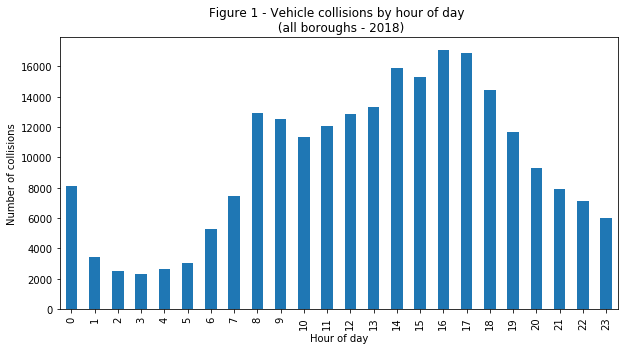

In [89]:
group = df1.groupby(df1.index.hour).count().unique_key
ax = group.plot(kind="bar", 
                figsize=(10, 5),
                title="Figure 1 - Vehicle collisions by hour of day \n (all boroughs - 2018)")

ax.set_xlabel("Hour of day")
_ = ax.set_ylabel("Number of collisions")

In [21]:
print(f"Mean collisions in early morning: {group[1:6].sum() / 5}")
print(f"Mean collisions in afternoon rush hour: {group[16:18].sum() / 2}")

Mean collisions in early morning: 2788.8
Mean collisions in afternoon rush hour: 16980.5


We do not have complete data for the boroughs in which collisions occur, but we can visualize the data we do have by borough as well.

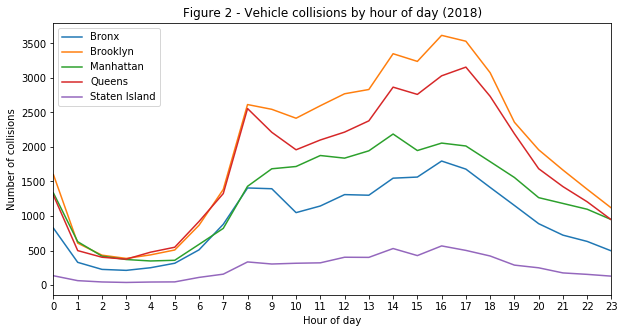

In [90]:
group = (df1.groupby([df1.index.hour, "borough"])
         .unique_key
         .count()
         .unstack())

ax = group.plot(figsize=(10, 5), 
                xticks=range(0, 24), 
                title="Figure 2 - Vehicle collisions by hour of day (2018)")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Number of collisions")

# rename the legends so values are not all uppercase 
boroughs = [str(b).title() 
            for b in df1.borough.dropna().unique()]
_ = ax.legend(boroughs)

We will discuss further in the conclusion, but the graphs reveal that most accidents occur during the day, particularly between the hours of 4:00 and 6:00pm.

<a id="days" />

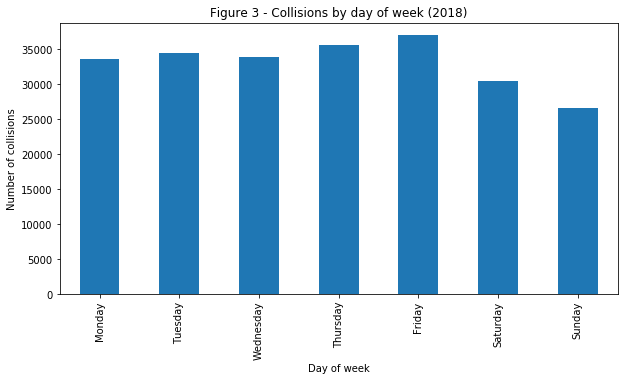

In [91]:
# order the grouped dataframe by day of week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group = (df1.groupby(["day_of_week"])
         .count()
         .unique_key
         .reindex(days))

ax = group.plot(figsize=(10, 5), 
           kind="bar", 
           title="Figure 3 - Collisions by day of week (2018)")

ax.set_xlabel("Day of week")
_ = ax.set_ylabel("Number of collisions")

More collisions also occur on weekdays than weekends.

In [16]:
print(f"Average collisions on weekdays {group[:5].sum() / 5}")
print(f"Average collisions on weekends {group[5:].sum() / 2}")

Average collisions on weekdays 34887.4
Average collisions on weekends 28524.0


#### III. Vehicle type <a id="types" />

#### a. Data preparation

We'll create a dataframe containing the relevant fields for answering the second question regarding the effect of vehicle type on injury and mortality rates.

In [22]:
df2 = df.drop(["date_time", "borough"], axis=1).copy()
df2 = df2.set_index("unique_key")
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231485 entries, 4055860 to 3820878
Data columns (total 13 columns):
number_of_persons_injured        231480 non-null float64
number_of_persons_killed         231471 non-null float64
number_of_pedestrians_injured    231485 non-null int64
number_of_pedestrians_killed     231485 non-null int64
number_of_cyclist_injured        231485 non-null int64
number_of_cyclist_killed         231485 non-null int64
number_of_motorist_injured       231485 non-null int64
number_of_motorist_killed        231485 non-null int64
vehicle_type_code_1              230088 non-null object
vehicle_type_code_2              182463 non-null object
vehicle_type_code_3              13853 non-null object
vehicle_type_code_4              2872 non-null object
vehicle_type_code_5              762 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 24.7+ MB


We note that there are 5 vehicle type fields for each collision and that the number of not-null values in columns 1 and 2 are an order of magnitude greater than the number of not-null values in columns 3, 4 and 5. In the following analysis, we'll examine just `vehicle_type_code_1` and `vehicle_type_code_2` in order to have a more manageble number of vehicle-type combinations to examine.

We create a new column called `vehicle_type` that contains just `vehicle_type_code_1` in the case that `vehicle_type_code_2` is null, and otherwise contains a sorted concatenation of the two fields.

In [23]:
# drop the approximately 1300 instances where there are no vehicle types
df2.dropna(subset=["vehicle_type_code_1"], inplace=True)

# combine the first two vehicle type columns with a "+" as the delimiter
df2["vehicle_type"] = (np.where(df2.vehicle_type_code_1 < df2.vehicle_type_code_2, 
                                   df2.vehicle_type_code_1.str.lower() + "+" + df2.vehicle_type_code_2.str.lower(), 
                                   df2.vehicle_type_code_2.str.lower() + "+" + df2.vehicle_type_code_1.str.lower()))

# if the column is null, then the second vehicle type is null, so use the first type
df2["vehicle_type"] = (np.where(df2.vehicle_type_code_2.isna(), 
                                  df2.vehicle_type_code_1.str.lower() + " only",
                                  df2.vehicle_type))

In [24]:
df2[["vehicle_type_code_1", "vehicle_type_code_2", "vehicle_type"]].head(10)

,vehicle_type_code_1,vehicle_type_code_2,vehicle_type
unique_key,,,
4055860,Sedan,NaN,sedan only
4055249,Sedan,NaN,sedan only
4055273,Sedan,Station Wagon/Sport Utility Vehicle,sedan+station wagon/sport utility vehicle
4055449,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,station wagon/sport utility vehicle+station wa...
4055005,Van,Sedan,sedan+van
4055499,Station Wagon/Sport Utility Vehicle,NaN,station wagon/sport utility vehicle only
4055512,Station Wagon/Sport Utility Vehicle,Sedan,sedan+station wagon/sport utility vehicle
4060683,Station Wagon/Sport Utility Vehicle,Sedan,sedan+station wagon/sport utility vehicle
4062834,Pick-up Truck,NaN,pick-up truck only


#### b. Mortality

In [27]:
df.number_of_persons_killed.sum()

227.0

We'll first examine the total number of fatalities by vehicle type.

<a id="fig4" />

Total number of fatalities: 223

Fatalities by vehicle type:
vehicle_type
station wagon/sport utility vehicle only          44.0
sedan only                                        22.0
passenger vehicle only                            14.0
sport utility / station wagon only                13.0
motorcycle+station wagon/sport utility vehicle    13.0
Name: number_of_persons_killed, dtype: float64


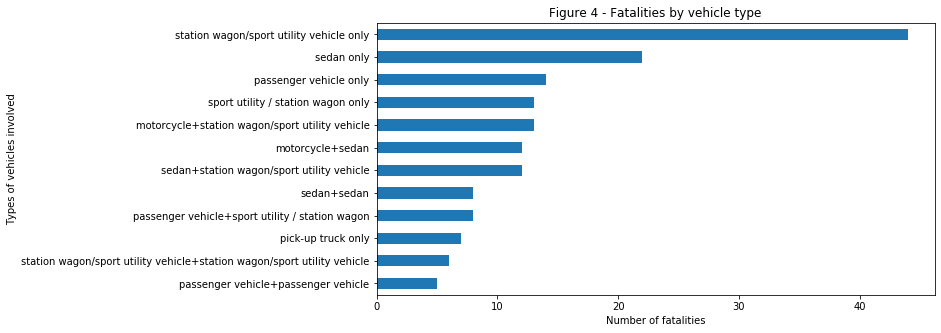

In [92]:
grouped = (df2[df2["number_of_persons_killed"] >= 1]
 .groupby("vehicle_type")
 .number_of_persons_killed
 .sum()
 .sort_values(ascending=False)
)
total_fatalities = int(grouped.sum())
print(f"Total number of fatalities: {total_fatalities}")

title = "Figure 4 - Fatalities by vehicle type"
ax = (grouped[grouped >= 5]
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of fatalities")
ax.set_ylabel("Types of vehicles involved")
print("\nFatalities by vehicle type:")
print(grouped.head())

We see that there were 223 total fatalities and that the top vehicle type was a single vehicle (SUV/station wagon, sedan or passenger vehicle). These appear to be cases where a pedestrian was struck and killed. Let's examine further to confirm.

Number of pedestrian fatalities: 116
Number of motorist fatalities: 97
Number of cyclist fatalities: 10


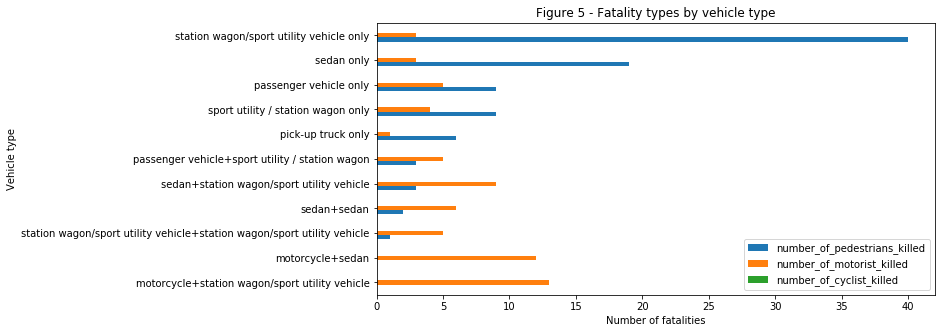

In [93]:
print(f"Number of pedestrian fatalities: {int(df2.number_of_pedestrians_killed.sum())}")
print(f"Number of motorist fatalities: {int(df2.number_of_motorist_killed.sum())}")
print(f"Number of cyclist fatalities: {int(df2.number_of_cyclist_killed.sum())}")

# look again only at vehicle types with more than 5 fatalities
top = grouped[grouped > 5]

dff = (df2[(df2["number_of_persons_killed"] >= 1) & (df2.vehicle_type.isin(top.index))] 
           .groupby(["vehicle_type"])
          )["number_of_pedestrians_killed", 
            "number_of_motorist_killed", 
            "number_of_cyclist_killed"].apply(lambda x : x.astype(int).sum())

ax = (dff.sort_values("number_of_pedestrians_killed", ascending=False)
     .iloc[::-1]
     .plot(figsize=(10, 5), 
           kind="barh",
           title="Figure 5 - Fatality types by vehicle type"))
 
ax.set_xlabel("Number of fatalities")
_ = ax.set_ylabel("Vehicle type")

The cases in which only a single vehicle is involved are typically pedestrian deaths. 

We also see a that a large number of fatalities included a motorcycle. Let's further examine this.

In [140]:
motorcycles = df2[df2.vehicle_type.str.contains("motorcycle")]
others = df2[~df2.vehicle_type.str.contains("motorcycle")]

percent_motorcycle = len(motorcycles) / len(df2) * 100
percent_motorcycle_fatal = int(motorcycles.number_of_persons_killed.sum() / total_fatalities * 100)

motorcycle_mean_fatalities = motorcycles.number_of_persons_killed.mean()
others_mean_fatalities = others.number_of_persons_killed.mean()
print(f"Percent of collisions involving a motorcycle: {percent_motorcycle:.2}%")
print(f"Percent of fatalities involving a motorcycle: {percent_motorcycle_fatal}%")
print()
print(f"Mean fatalities for collisions involving a motorcycle: {motorcycle_mean_fatalities:.2}")
print(f"Mean fatalities for collisions not involving a motorcycle: {others_mean_fatalities:.2}")

Percent of collisions involving a motorcycle: 0.88%
Percent of fatalities involving a motorcycle: 14%

Mean fatalities for collisions involving a motorcycle: 0.016
Mean fatalities for collisions not involving a motorcycle: 0.00083


It appears that collisions involving a motorcycle are much more likely to result in a fatality. Let's conduct a t-test to confirm that this is a signifincat result. 

In [143]:
target = "number_of_persons_killed"
ttest_ind(motorcycles.dropna(subset=[target]).number_of_persons_killed, 
          others.dropna(subset=[target]).number_of_persons_killed)

Ttest_indResult(statistic=22.0470164544321, pvalue=1.319883655291921e-107)

We find that collisions involving motorcycles are more likely to include a fatality than collisions involving other vehicle types.

#### c. Injury

<a id="fig6" />

Total number of injuries: 60889

vehicle_type
sedan+station wagon/sport utility vehicle                                  9693.0
sedan+sedan                                                                7839.0
station wagon/sport utility vehicle+station wagon/sport utility vehicle    4469.0
passenger vehicle+sport utility / station wagon                            4275.0
sedan only                                                                 4223.0
passenger vehicle+passenger vehicle                                        3554.0
station wagon/sport utility vehicle only                                   3276.0
passenger vehicle only                                                     2165.0
sport utility / station wagon+sport utility / station wagon                2067.0
sport utility / station wagon only                                         1698.0
bike+sedan                                                                 1452.0
bike+station wagon/sport utility vehicle            

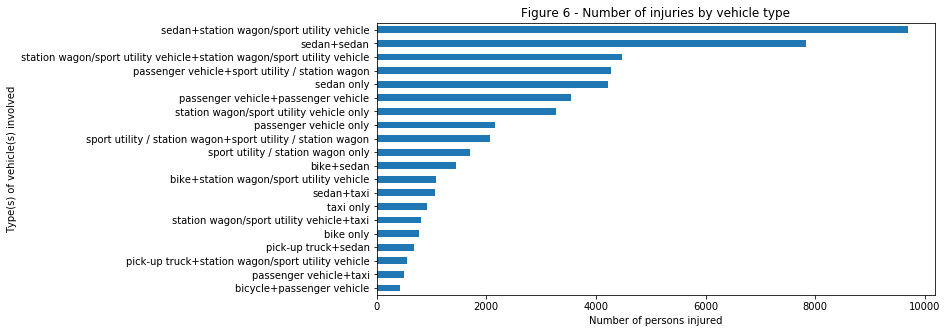

In [95]:
grouped = (df2[df2["number_of_persons_injured"] >= 1]
 .groupby("vehicle_type")
 .number_of_persons_injured
 .sum()
 .sort_values(ascending=False)
)
total_injuries = int(grouped.sum())
print(f"Total number of injuries: {total_injuries}\n")

title = "Figure 6 - Number of injuries by vehicle type"
ax = (grouped.head(20)
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of persons injured")
ax.set_ylabel("Type(s) of vehicle(s) involved")
print(grouped.head(20))

Total number of injuries: 60889

vehicle_type
sedan+station wagon/sport utility vehicle                                  9693.0
sedan+sedan                                                                7839.0
station wagon/sport utility vehicle+station wagon/sport utility vehicle    4469.0
passenger vehicle+sport utility / station wagon                            4275.0
sedan only                                                                 4223.0
passenger vehicle+passenger vehicle                                        3554.0
station wagon/sport utility vehicle only                                   3276.0
passenger vehicle only                                                     2165.0
sport utility / station wagon+sport utility / station wagon                2067.0
sport utility / station wagon only                                         1698.0
bike+sedan                                                                 1452.0
bike+station wagon/sport utility vehicle            

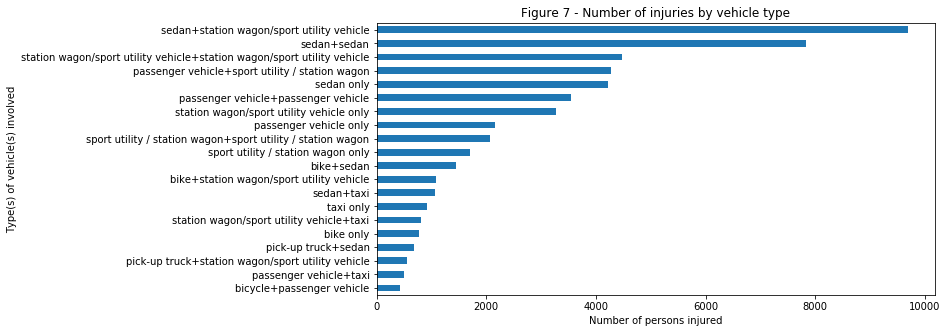

In [96]:
grouped = (df2.groupby("vehicle_type")
           .number_of_persons_injured
           .sum()
           .sort_values(ascending=False))

total_injuries = int(grouped.sum())
print(f"Total number of injuries: {total_injuries}\n")

title = "Figure 7 - Number of injuries by vehicle type"
ax = (grouped.head(20)
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of persons injured")
ax.set_ylabel("Type(s) of vehicle(s) involved")
print(grouped.head(20))

In [98]:
inj = (df2.groupby("vehicle_type")
       .vehicle_type
       .count())
inj = inj[inj > .001 * len(df2)]
inj.head()

vehicle_type
bicycle+passenger vehicle                    532
bicycle+sport utility / station wagon        379
bike only                                    836
bike+sedan                                  1810
bike+station wagon/sport utility vehicle    1346
Name: vehicle_type, dtype: int64

vehicle_type
ds+sport utility / station wagon                                           1.916667
bus+station wagon/sport utility vehicle                                    1.882716
bu+sport utility / station wagon                                           1.761905
bus+sedan                                                                  1.734884
bus+taxi                                                                   1.708333
station wagon/sport utility vehicle+taxi                                   1.700422
sedan+taxi                                                                 1.643411
station wagon/sport utility vehicle+van                                    1.603774
sedan+sedan                                                                1.601430
station wagon/sport utility vehicle+station wagon/sport utility vehicle    1.597783
sedan+station wagon/sport utility vehicle                                  1.584341
passenger vehicle+passenger vehicle                            

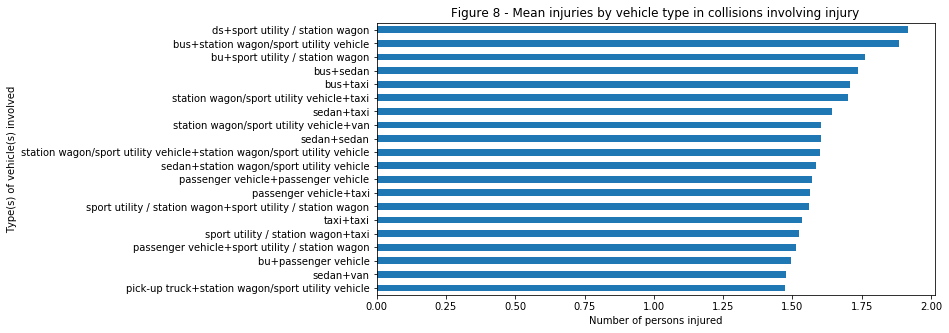

In [99]:
dfi = df2[df2.vehicle_type.isin(inj.index)]
grouped = (dfi[dfi["number_of_persons_injured"] >= 1]
 .groupby("vehicle_type")
 .number_of_persons_injured
 .mean()
 .sort_values(ascending=False)
)
grouped.head(20)

title = "Figure 8 - Mean injuries by vehicle type in collisions involving injury"
ax = (grouped.head(20)
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of persons injured")
ax.set_ylabel("Type(s) of vehicle(s) involved")
print(grouped.head(20))

In [265]:
taxi = df2[(df2.vehicle_type.str.contains("taxi")) & (df2.number_of_persons_injured > 0)]
non_taxi = df2[~df2.vehicle_type.str.contains("taxi") & (~df2.vehicle_type.str.contains("bus")) & (df2.number_of_persons_injured > 0)]
len(non_taxi)

40452

In [266]:
print(taxi.number_of_persons_injured.mean())
non_taxi.number_of_persons_injured.mean()

1.3995440296380735


1.3588450509245527

In [223]:
target = "number_of_persons_injured"
ttest_ind(taxi.dropna(subset=[target]).number_of_persons_injured, 
          non_taxi.dropna(subset=[target]).number_of_persons_injured)

Ttest_indResult(statistic=-0.7887631115893325, pvalue=0.43025128607465657)

In [215]:
df2[(df2.vehicle_type=="bus+sport utility / station wagon") & (df2["number_of_persons_injured"] >= 1)]

,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,vehicle_type
unique_key,,,,,,,,,,,,,,


In [48]:
dff[dff["number_of_persons_killed"] != dff["number_of_pedestrians_killed"] + \
         dff["number_of_cyclist_killed"] + dff["number_of_motorist_killed"]]

,number_of_persons_killed,number_of_pedestrians_killed,number_of_cyclist_killed,number_of_motorist_killed,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
unique_key,,,,,,,,,
4025853,1.0,0,0,0,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [518]:
injury["number_of_persons_injured"].sum()

61922.0

#### IV. Discussion

##### a. Introduction
In the above notebook, we examine the approximately 230,000 collisions recorded by the NYPD in 2018 in order to answer questions the following questions:

1.	In 2018, what were the best and worst times to be driving if collision safety was your only consideration?
2.	In 2018, what effect did vehicle type have on injury and mortality rate given an accident?

##### b. Collision times
With respect to the first question, we find that the fewest collisions occur in the early morning hours, between approximately 1:00am and 6:00am (a total of 2,800 collisions per hour in that timespan). The most collisions occur during the evening rush hour, particularly between 4:00pm and 6:00pm (17,000 collisions per hour). These findings hold accross all five boroughs (see [Figures 1 and 2](#by-hour)). We also find that there are fewer collisions on weekends than on weekdays (a total of approximately 29,000 per day on weekends and 35,000 per day on weekdays - see [Figure 3](#days)).

We note that the collision dataset does not include the number of cars on the road at a given time, so we cannot conclude that an individual driver is less likely to be involved in a collision early in the morning or on a weekend. While there are fewer total collisions during these times, there are also likely fewer cars on the road and so fewer non-collisions as well.

##### c. Vehicle types

There are 223 fatalities in the dataset for which at least one vehicle type was recorded, and 116 of these fatalities are pedestrian deaths. The type of vehicle most often recorded for a pedestrian death is a _station wagon/sport utility vehicle_ (see [Figures 4 and 5](#fig4)). Because this is a common type of vehicle in the dataset and because there are a large number of vehicle types in the dataset, we cannot say whether a pedestrian struck by an SUV is more likely to die than when struck by any other vehicle type without further analysis.

With respect motorist fatalities, we find that a significant number are associated with motorcycles. While motorcycles are involved in less than 1% of collisions, 14% of fatalities are associated with collisions that involve one or more motorcycles.

Of the 44,575 collisions that resulted in injury, the mean number of injuries was less than 2 accross vehicle types. The mean number of injuries was slightly higher for buses, but this is not surprising given that there are more passengers on buses than on other types of vehicles. We find that when taxis are involved in collisions that result in injury, the mean number of injuries is slightly higher than when taxis are not involved. We hypothesize that this might be due to passengers not wearing seatbelts in taxis, though it is also possible that taxis carry more passengers on average than other vehicle types.